# Аналитика и преоритизация гипотиз крупного интернет-магазина с целью снижение расходов на проверку гипотиз.

 ## Описание проекта
 Оновной цельлью проверяемых гипотиз, является повышение выручки.
 Также в проекте будет произведен анализ А/B теста.
 ## Описание данных
 - Таблица с гипотизами в дальнейшем именуемая hypothesis, содержит 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.
 - Таблицы с результатами А/B теста, в таблицах, далее именуемые orders и visitors.

<a id="id0"></a>
## Содержание: 

[0. **Шаг 0. Выгрузка данных и подключение необходимых бибиотек.**](#id01)<br>
[1. **Шаг 1. Приоритизация гипотез.**](#id1)<br>
[2. **Шаг 2. Анализ A/B-теста.**](#id2)<br>

<a id="id01"></a>
## Шаг 0. Выгрузка данных и подключение необходимых бибиотек.
[к содержанию](#id0)<br>

In [1]:
#подключение библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
#выгрузка данных
try:
    hypothesis = pd.read_csv('C:/projects/hypothesis.csv')
    orders = pd.read_csv('C:/projects/orders.csv')
    visitors = pd.read_csv('C:/projects/visitors.csv')
except:
    hypothesis = pd.read_csv(r'/datasets/hypothesis.csv')
    orders = pd.read_csv(r'/datasets/orders.csv')
    visitors = pd.read_csv(r'/datasets/visitors.csv')

In [3]:
#изучение данных
for key, value in {'гипотезы':hypothesis, 'заказы':orders,'визиты':visitors}.items():
    print('\033[1m' + 'Таблица с данными', key + '\033[0m')
    print ('\033[1m' + 'Вывод метода info()' + '\033[0m')
    value.info()
    print ('\033[1m' + 'Просмотр первых строк таблицы' + '\033[0m')
    print(value.head(5))
    print('\033[1m' +'----------------------------' + '\033[0m')
#проверка на поподание пользователей в разные группы одновременно
a = orders[orders['group']=='A']
temp = a[a['visitorId'].isin(orders[orders['group']=='B']['visitorId'])]
print('Колчество пользователей попавших в обе группы:', temp.shape[0],'человек, это {:.2%} процентов всех данных.'.format(temp.shape[0]/orders['visitorId'].nunique()))

Таблица с данными гипотезы
Вывод метода info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
Просмотр первых строк таблицы
                                          Hypothesis  Reach  Impact  \
0  Добавить два новых канала привлечения трафика,...      3      10   
1  Запустить собственную службу доставки, что сок...      2       5   
2  Добавить блоки рекомендаций товаров на сайт ин...      8       3   
3  Изменить структура категорий, что увеличит кон...      8       3   
4  Изменить цвет фона главной страницы, чтобы уве...      3       1   

   Confidence  Efforts  
0           8        6  
1          

In [4]:
# Пример:

#разделим заказы на 2 датасета по группам
group_a = orders.query('group == "A"')
group_b = orders.query('group == "B"')
# объединим их по условию совпадения id пользователя
group_both = group_a.merge(group_b, on ='visitorId', how = 'inner')
# выведем количество пользователей, которые попали в обе группы
display(len(group_both['visitorId'].value_counts()))

58

****Справка:**** Изучив, мета данные и данные в таблицах, в отношении предобработки, пропуски не обноружены, как и дубликаты. Обнаружены пересекающиеся пользователи в разных группах, процент их содержания давольно велик, поэтому они не отбрасываются. Каждый неопределенный покупатель, будет распределен в группу, присвоенную ему в первую покупку. Также необходимо, имена столбцов в таблице hypothesis, привести к общему регистру и произвести замену типов данных, для:

    таблицы orders в столбце date
    таблицы visitors в столбце date

В окне ниже производится вся предобработка данных.

In [5]:
orders['date'] =orders['date'].astype('datetime64[D]')
visitors['date'] = visitors['date'].astype('datetime64[D]')
hypothesis.columns = hypothesis.columns.str.lower()
#распределение по группам 'неопределившихся'
first_group = orders.sort_values(by='date',ascending=True).groupby('visitorId',as_index=False).first()[['visitorId','group']]
del orders['group']
orders = orders.merge(first_group, on = 'visitorId')

<a id="id2"></a>
## Шаг 1. Приоритизация гипотез.
[к содержанию](#id0)<br>

Ниже, к параметрам приоритезации гипотиз применяются фреймворки ICE и RICE с последующим аналитическим сравнением.
### применение фрэмворка ICE:
$$ICE = \frac{Impact * Confidence}{Efforts}$$

In [6]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis = hypothesis.sort_values(by= 'ice',ascending=False)
print('\033[1m' +'РЕЗУЛЬТАТЫ:'+'\033[0m')
pd.set_option("max_colwidth", 666)
hypothesis[['hypothesis','ice']].head(5)

РЕЗУЛЬТАТЫ:


,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000


### применение фрэмворка RICE:
$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [7]:
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis = hypothesis.sort_values(by= 'rice',ascending=False)
print('\033[1m' +'РЕЗУЛЬТАТЫ:'+'\033[0m')
hypothesis[['hypothesis','rice']].head(5)

РЕЗУЛЬТАТЫ:


,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2


#### ВЫВОД:
    С изменением фрэймфорков приоритезации гипотиз, как видно на первых пяти строк данных, заметно изменилась. 
    RICE имеет парметр охвата пользователей, в некоторых случаях его можно вполне конкретно посчитать, тогда как ICE, не предусматривает обьем влияния изменений, и вполне возможно, что гипотиза окажется малозначительной на фоне всего бизнеса.

<a id="id2"></a>
## Шаг 2. Анализ A/B-теста.
[к содержанию](#id0)<br>


In [8]:
pd.reset_option("max_colwidth")
#используемые функции 
def cum_pivot_table(data, values): #возвращает перевернутую сводную таблицу по параметру в группах
    return data.pivot_table(index='group', columns='date', values=values).cumsum(axis=1).T.reset_index()
def plot_group(data,ylabel): #строит графики по группам из столбцов
    ax = data.plot(x='date',y='A')
    plt.ylabel(ylabel)
    data.plot(x='date',y='B',ax=ax,figsize=(16,4))
    plt.show()
def plot_group_comparison(data,data_cl,ylabel): #сравнение с чистыми
    ax = data.plot(x='date',y='A',alpha=0.3)
    ax1 = data.plot(x='date',y='B',alpha=0.3,ax=ax)
    ax2 = data_cl.plot(x='date',y='A',ax=ax1)
    plt.ylabel(ylabel)
    data_cl.plot(x='date',y='B',figsize=(16,4),ax=ax2)
    plt.show()   
def plot_relative(data,ylabel): #строит графики относительной изменчивости
    temp = data
    temp['relative'] = data['B']/data['A']-1
    temp.plot(x='date',y='relative',figsize=(16,4))
    plt.ylabel(ylabel)
    plt.axhline(y=0,color='black',linestyle='--',alpha=0.5)
    plt.show()
def plot_relative_comparison(data,data_cl,ylabel): #строит графики относительной изменчивости
    temp = data.copy()
    temp_cl = data.copy()
    temp['relative'] = data['B']/data['A']-1
    temp_cl['relative'] = data_cl['B']/data_cl['A']-1
    ax = temp.plot(x='date',y='relative',figsize=(16,4),alpha=0.3)
    temp_cl.plot(x='date',y='relative',figsize=(16,4),ax=ax)
    plt.ylabel(ylabel)
    plt.axhline(y=0,color='black',linestyle='--',alpha=0.5)
    plt.show()    
alpha =0.05
def hypophes(result):
    if (result<alpha/2):
        print('Нулевая гипотиза не принемается')
    else: print('Нулевая гипотиза не отвергается')  

### Исследование кумулятивной выручки по группам

РЕЗУЛЬТАТЫ:
Графики изменеия кумулятивной выручки по группам:


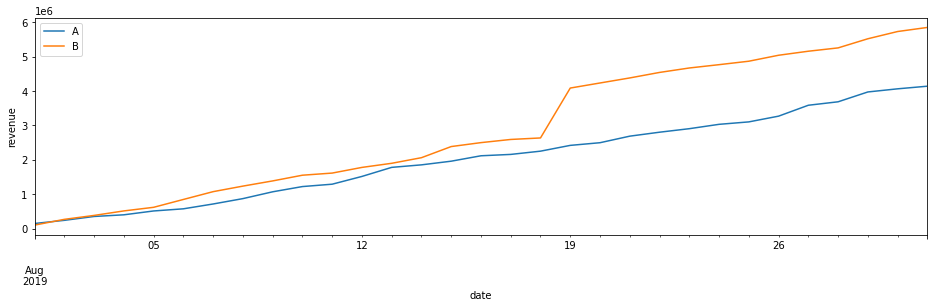

In [9]:
print('\033[1m' +'РЕЗУЛЬТАТЫ:'+'\033[0m') 
print('Графики изменеия кумулятивной выручки по группам:')
group_orders = orders.groupby(['group','date'],as_index=False).agg({'transactionId':'nunique','revenue':'sum'})
group_orders.columns = ['group','date','transactions','revenue']
cumRevenue = cum_pivot_table(group_orders,'revenue')
plot_group(cumRevenue,'revenue')

#### ВЫВОД: 
    - На графиках видно, что группа B к 19 ому числу имеет резкий скачек в прибыли, в сравнении с группой А. В случае отсутсвия проведения рекламных компаний, это явление может быть вызванно одной крупной или оптовой закупкой товаров. 
---------

### Исследование кумулятивного среднего чека по группам

РЕЗУЛЬТАТЫ:
Графики изменения кумулятивного среднего чека группы B к группе А:


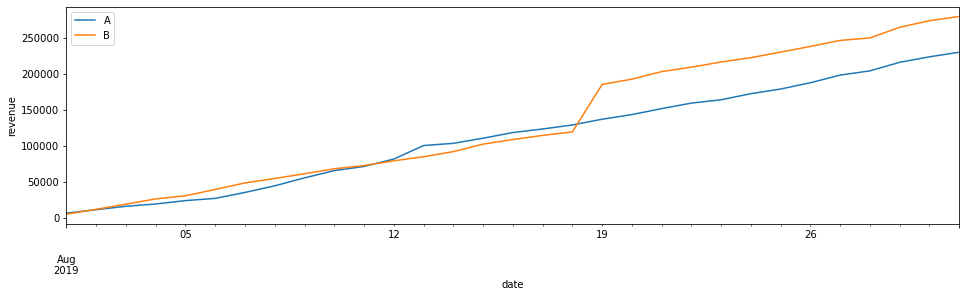

------------------------------------------------------------------------------------------------
График относительного изменения кумулятивного среднего чека группы B к группе А:


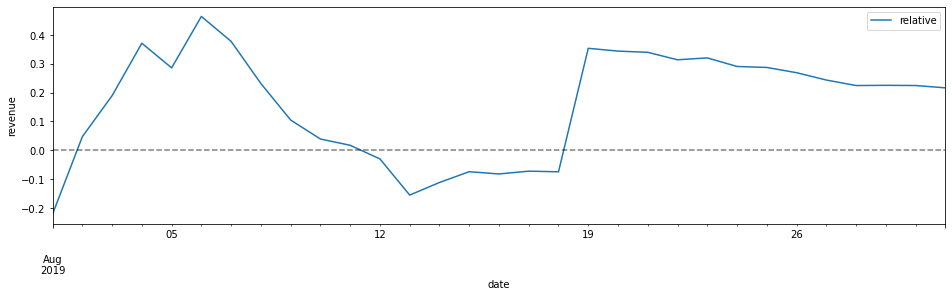

In [10]:
print('\033[1m' +'РЕЗУЛЬТАТЫ:'+'\033[0m')
print('Графики изменения кумулятивного среднего чека группы B к группе А:')
group_orders['middle'] = group_orders['revenue'] / group_orders['transactions']
middle = cum_pivot_table(group_orders,'middle')
plot_group(middle,'revenue')
print('\033[1m' +'------------------------------------------------------------------------------------------------' + '\033[0m')
print('График относительного изменения кумулятивного среднего чека группы B к группе А:')
plot_relative(middle,'revenue')

#### ВЫВОД:
    - Как видно из графиков изменения кумулятивного среднего чека, заметен тот же скачек для группы В. Значит присутствуют какие то выбросы по сумме покупки.
    - График относительного изменения показывает, что группа В привалирует над группой А, имеет просадку с 7 по 19 число. В дальнейшем, группа В компенсируется на прежний курс. Однако компенсация для группы Б, 18-19 августа совпадает с колебанием прибыли и в случае влияния выброса, наблюдаемая картина не является обьективной. 
---------

### Исследование кумулятивной конверсии по группам

РЕЗУЛЬТАТЫ:
Графики кумулятивной конверсии по группам:


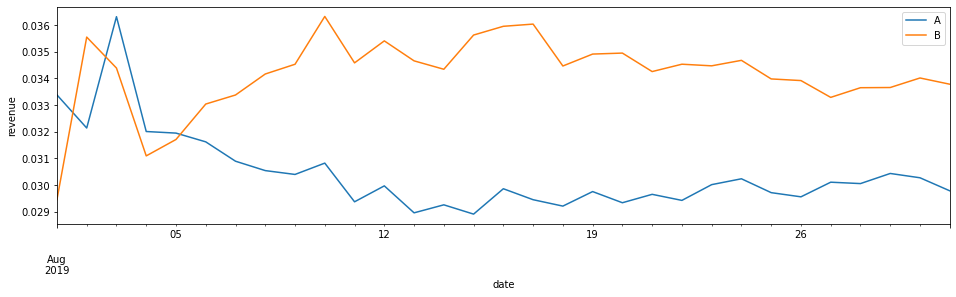

------------------------------------------------------------------------------------------------
График изменеия кумулятивной конверсии по группам:


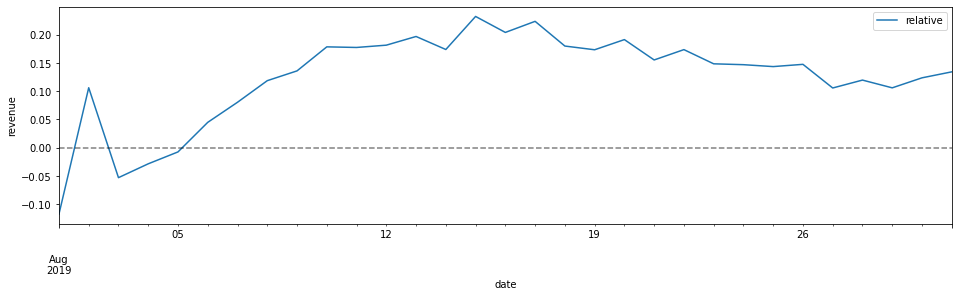

In [11]:
print('\033[1m' +'РЕЗУЛЬТАТЫ:'+'\033[0m')
print('Графики кумулятивной конверсии по группам:')
data = group_orders.merge(visitors,on=['group','date'])
#то что было
'''data['conversion'] = data['transactions']/data['visitors']
conversion = cum_pivot_table(data,'conversion')
plot_group(conversion,'revenue')
print('\033[1m' +'------------------------------------------------------------------------------------------------' + '\033[0m')
print('График изменеия кумулятивной конверсии по группам:')
plot_relative(conversion,'revenue')'''
#то что добавилось
cum_orders = cum_pivot_table(data,'transactions')
cum_orders.columns = ['date','ordersA','ordersB']
cum_visitors = cum_pivot_table(data,'visitors')
cum_visitors.columns = ['date','visitorsA','visitorsB']
cum_conversion = cum_visitors.merge(cum_orders,on='date')
cum_conversion['A'] = cum_conversion['ordersA']/cum_conversion['visitorsA']
cum_conversion['B'] = cum_conversion['ordersB']/cum_conversion['visitorsB']
plot_group(cum_conversion,'revenue')
print('\033[1m' +'------------------------------------------------------------------------------------------------' + '\033[0m')
print('График изменеия кумулятивной конверсии по группам:')
plot_relative(cum_conversion,'revenue')

#### ВЫВОД: 
     - На графиках видно, что конверсия группы B растет более активно, чем группы A
     - График относительной конверсии показывает, что в значчительной мерепревалирует группа B. 
---------

### Отсеивание количества заказов по пользователям

РЕЗУЛЬТАТЫ:
Точечный график количества заказов по пользователям:


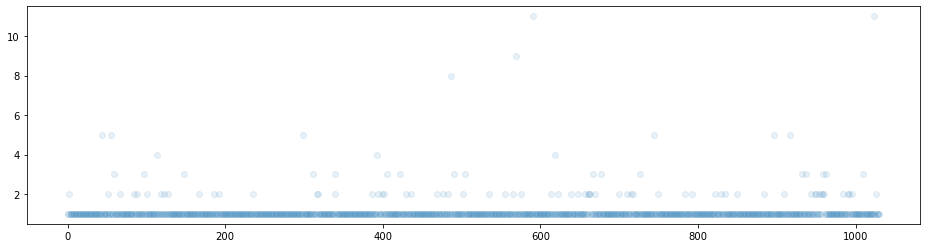

------------------------------------------------------------------------------------------------
Подсчет 95-ого и 99-ого перцентелей количества заказов на пользователя:

min = 1
95 percentele = 2.0
97 percentele = 2.0
99 percentele = 4.0
max = 11


In [12]:
print('\033[1m' +'РЕЗУЛЬТАТЫ:'+'\033[0m') 
print('Точечный график количества заказов по пользователям:')
count_orders = orders.groupby('visitorId',as_index=False).agg({'transactionId':'nunique'})
plt.figure(figsize=(16,4))
plt.scatter(count_orders.index,count_orders['transactionId'],alpha=0.1)
plt.show()
print('\033[1m' +'------------------------------------------------------------------------------------------------' + '\033[0m')
print('Подсчет 95-ого и 99-ого перцентелей количества заказов на пользователя:')
print()
temp = np.percentile(count_orders['transactionId'],[95,97,99])
print('min =',count_orders['transactionId'].min())
print('95 percentele =',temp[0])
print('97 percentele =',temp[1])
print('99 percentele =',temp[2])
print('max =',count_orders['transactionId'].max())

#### ВЫВОД: 
    - Из точечной диаграммы видно, что огромная часть поьзователей делают по одному заказу, а также присутствует не мало выбросов. Вполне естественно, что некоторая часть людей, делают два заказа в месяц. Имея представление о сегменте рынка магазина, для которого производится А/В тестирование можно было бы сказать точно, является ли это ошибкой при сборе данных (маловозможно) или это естественное проявление покупательской способности. 
    - В качестве границы принемается 97 перцентиль, именно на нем увеличивается плотность шага количества покупок на покупателя. Это значение выбрано чтобы показать, что отбрасываемая часть не является самой большой, при допустимых изьятиях данных в 1%-5%.
---------

### Распределение стоимостей заказов по пользователям

РЕЗУЛЬТАТЫ:
Точечный график стоимостей заказов по пользователям:


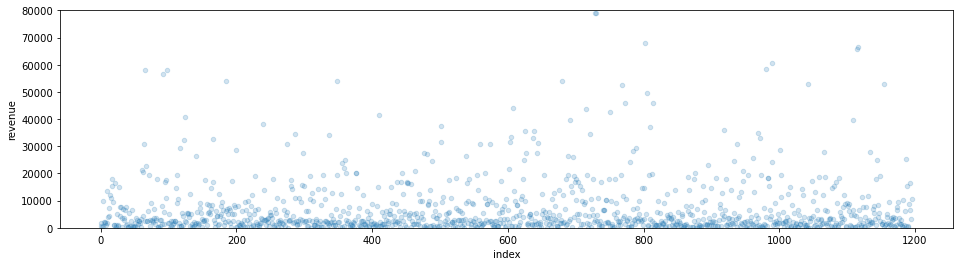

------------------------------------------------------------------------------------------------
Распределение данных в цифрах:

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

Посчет 95-ого и 99-ого перцентелей количества заказов на пользователя:
min = 50
95 percentele = 28000.00
99 percentele =58233.20
max = 1294500


In [13]:
print('\033[1m' +'РЕЗУЛЬТАТЫ:'+'\033[0m') 
print('Точечный график стоимостей заказов по пользователям:')
temp = orders.reset_index() #это сделано чтобы можнобыло бы задать границы данных на графике 
temp.plot.scatter(x='index',y='revenue', alpha=0.2,figsize=(16,4),ylim=(0,8e4))
plt.show()
print('\033[1m' +'------------------------------------------------------------------------------------------------' + '\033[0m')
print('Распределение данных в цифрах:')
print()
print(temp['revenue'].describe())
print()
#перцентели
print('Посчет 95-ого и 99-ого перцентелей количества заказов на пользователя:')
temp = np.percentile(orders['revenue'],[95,99])
print('min =',orders['revenue'].min())
print('95 percentele = {:.2f}'.format(temp[0]))
print('99 percentele ={:.2f}'.format(temp[1]))
print('max =',orders['revenue'].max())

#### ВЫВОД: 
    - На точечной диаграмме видно много заказов до 10000, но те что дороже распределены не так редко, чтобы их не учитывать. Интернет магазин имеет много товаров и большой диапозон цен, поэтому подобная картина распределения впоне нормальная. 
    - За пограеичное значение выбросов и полезных значений выберется 99 перцентель равный 58233.
---------

### Подсчет статистической значимости различий в конверсии и среднем чеке по «серым» данным.

-  Используя собранные данные из А/B тестирования проверяется гипотиза, которая для проверки формируютя в две гипотизы, нулевую и альтернаиивную. H0 - нулевая гипотиза говорит, что конверсия группы А совпадает с конверсией группы В, а альтернативнвая Н1, что конверсия групп различна. Для проверки статистической значимости для независимых выборок используется двусторонний метод Манна-Уитни.
-  Для проверки статистически значимого различия среднего чека по необработанным данным, так же формулируются две гипотизы H0 и H1. H0 - средние чеки двух групп равны, H1 - средние чеки групп А и Б не равны.

In [14]:
#количество заказов на пользователя по группам
ordersUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersUsersA.columns = ['users','orders']
ordersUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersUsersB.columns = ['users','orders']
#количество виситеров без покупок
count_visitors = data.groupby('group', as_index=False).agg({'visitors':'sum'})
a = pd.Series(0, index=np.arange(count_visitors['visitors'][0] - len(ordersUsersA['orders'])), name='orders')
b = pd.Series(0, index=np.arange(count_visitors['visitors'][1] - len(ordersUsersB['orders'])), name='orders')
sampleA  = pd.concat([ordersUsersA['orders'],a],axis=0)
sampleB  = pd.concat([ordersUsersB['orders'],b],axis=0)
result_conv_dirty =  st.mannwhitneyu(sampleA, sampleB,alternative='two-sided')[1]
print('\033[1m' +'РЕЗУЛЬТАТЫ:'+'\033[0m') 
print('Проверка гипотиз о конверсии на необработанных данных:')
print(f"Cтатистическая значимость различий в конверсии: {result_conv_dirty:.3f}")
print("Относительные различия в конверсий между группами: {0:.3f}".format(sampleB.mean()/sampleA.mean() - 1))
hypophes(result_conv_dirty)
print('\033[1m' +'------------------------------------------------------------------------------------------------' + '\033[0m')
print('Проверка гипотиз о среднем чеке на необработанных данных:')
result_middle_dirty = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'],alternative='two-sided')[1]
print(f'Cтатистическая значимость различий среднего чека: {result_middle_dirty:.3f}')
print('Относительные различия среднего чека между группами: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 
hypophes(result_middle_dirty)

РЕЗУЛЬТАТЫ:
Проверка гипотиз о конверсии на необработанных данных:
Cтатистическая значимость различий в конверсии: 0.010
Относительные различия в конверсий между группами: 0.134
Нулевая гипотиза не принемается
------------------------------------------------------------------------------------------------
Проверка гипотиз о среднем чеке на необработанных данных:
Cтатистическая значимость различий среднего чека: 0.644
Относительные различия среднего чека между группами: 0.234
Нулевая гипотиза не отвергается


#### ВЫВОД:
    - Проверка гипотиз на стат. значимость различий в конверсии между группами по «серым» данным показало, что имеются основания не принемать нулевую гипотизу о равенстве конверсий между группами. Относительное различие показывает, что группа B имеет большую конверсию.
    - Проверка гипотиз на стат. значимость различий в среднем чеке заказа между группами по «серым» данным, показало, что  причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.
    - Основываясь на 'серых' данных, предворительный вывод говорит, что решения по изменению сайта в значительной мере повлияли на конверсию в лучшую сторону. Изменения в значимой степени, никак не повлияли на изменение среднего чека.
----

### Изучение информации по «очищенным» данным и подсчет статистической значимости различий в конверсии и среденем чеке, между группами. 

#### Кумулятивной выручка. 

РЕЗУЛЬТАТЫ:
Графики изменеия кумулятивной выручки по группам(сравнение "чистых" и "серых" данных):


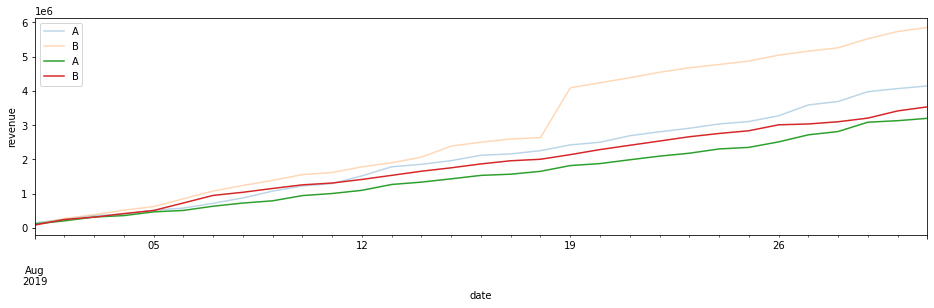

In [15]:
#ПОДГОТОВКА ДАННЫХ
usersWithExpensiveOrders = orders.query('revenue>58200')['visitorId']
usersWithManyOrders  = count_orders.query('transactionId>2')['visitorId']
shiny_users = pd.concat([usersWithExpensiveOrders,usersWithManyOrders]).reset_index(drop=True)
#чистые ордеры
orders_clean = orders.query('visitorId not in @shiny_users')
group_orders_clean = orders_clean.groupby(['date','group'],as_index=False).agg({'transactionId':'nunique','revenue':'sum'})
group_orders_clean.columns = ['date','group','transactions','revenue']
print('\033[1m' +'РЕЗУЛЬТАТЫ:'+'\033[0m')
#график кумулятивной выручки
print('Графики изменеия кумулятивной выручки по группам(сравнение "чистых" и "серых" данных):')
cumRevenue_cl = cum_pivot_table(group_orders_clean,'revenue')
plot_group_comparison(cumRevenue,cumRevenue_cl,'revenue')

#### ВЫВОД: 
    - На графиках заметны последствия очистки данных - группа B потеряла свой характерный выступ и рост для обоих групп стал менее активным. Взаимное же расположение сохранилось, группа В распологается выше группы А. 
---------

#### Кумулятивный средний чек. 

РЕЗУЛЬТАТЫ:
Графики изменения кумулятивного среднего чека группы B к группе А(сравнение "чистых" и "серых" данных):


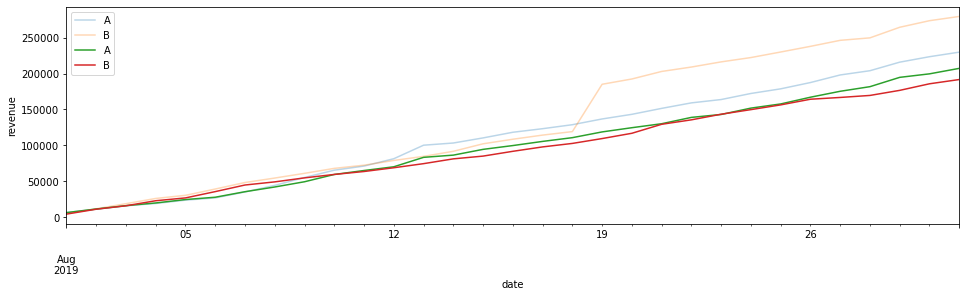

------------------------------------------------------------------------------------------------
График относительного изменения кумулятивного среднего чека группы B к группе А(сравнение "чистых" и "серых" данных):


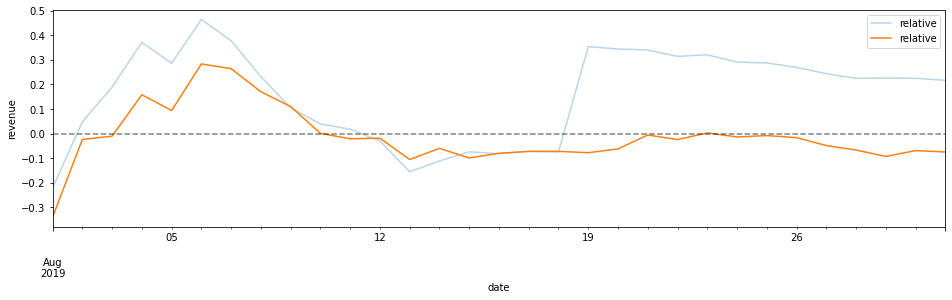

In [16]:
print('\033[1m' +'РЕЗУЛЬТАТЫ:'+'\033[0m')
print('Графики изменения кумулятивного среднего чека группы B к группе А(сравнение "чистых" и "серых" данных):')
#графики кумулятивного среднего чека
group_orders_clean['middle'] = group_orders_clean['revenue'] / group_orders_clean['transactions']
middle_cl = cum_pivot_table(group_orders_clean,'middle')
plot_group_comparison(middle,middle_cl,'revenue')
print('\033[1m' +'------------------------------------------------------------------------------------------------' + '\033[0m')
print('График относительного изменения кумулятивного среднего чека группы B к группе А(сравнение "чистых" и "серых" данных):')
plot_relative_comparison(middle,middle_cl,'revenue')

#### ВЫВОД:
    - Очистка данных, выровнила графики среднего чека и немного занизила активность роста, но попрежнему сохроняется тенденция паралельного роста.
    - Изменилась тенденция относительного среднего чека, ранее сделанное предположение оказалось не верным. Первые полторы недели наблюдались колебания, в дальнейшем график в большую часть времени держался  не далеко от границы равновесия, на стороне группы A. 
---------

#### Кумулятивная конверсия. 

РЕЗУЛЬТАТЫ:
Графики кумулятивной конверсии по группам(сравнение "чистых" и "серых" данных):


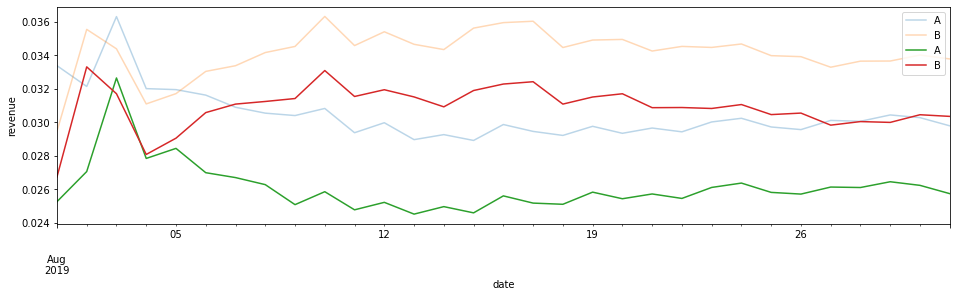

------------------------------------------------------------------------------------------------
График изменения относительной кумулятивной конверсии по группам(сравнение "чистых" и "серых" данных):


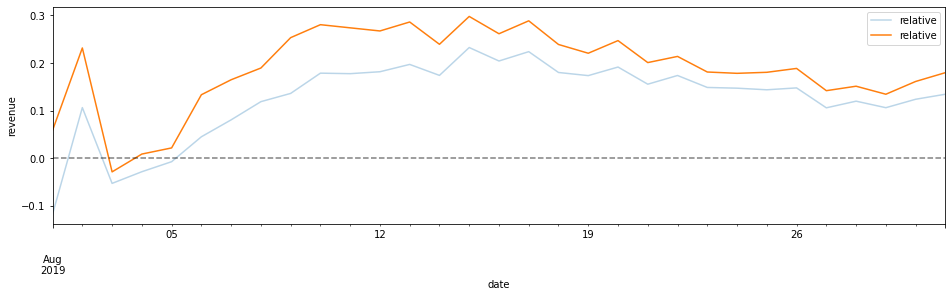

In [17]:
#исключение ярких пользователей из данных о визитах
temp = orders[orders['visitorId'].isin(shiny_users)].groupby(['group','date'], as_index=False).agg({'visitorId':'count'})
visitors_clean = visitors.merge(temp,on=['group','date'],how='outer').fillna(0)
visitors_clean['visitors_clean'] = visitors_clean['visitors'] - visitors_clean['visitorId']
visitors_clean = visitors_clean[['date','group','visitors_clean']].copy()
#чистая data
data_clean = group_orders_clean.merge(visitors_clean,on=['group','date'])
print('\033[1m' +'РЕЗУЛЬТАТЫ:'+'\033[0m')
print('Графики кумулятивной конверсии по группам(сравнение "чистых" и "серых" данных):')
cum_orders_cl = cum_pivot_table(data_clean,'transactions')
cum_orders_cl.columns = ['date','ordersA','ordersB']
cum_visitors_cl = cum_pivot_table(data_clean,'visitors_clean')
cum_visitors_cl.columns = ['date','visitorsA','visitorsB']
cum_conversion_cl = cum_visitors_cl.merge(cum_orders_cl,on='date')
cum_conversion_cl['A'] = cum_conversion_cl['ordersA']/cum_conversion_cl['visitorsA']
cum_conversion_cl['B'] = cum_conversion_cl['ordersB']/cum_conversion_cl['visitorsB']
plot_group_comparison(cum_conversion,cum_conversion_cl,'revenue')
print('\033[1m' +'------------------------------------------------------------------------------------------------' + '\033[0m')
print('График изменения относительной кумулятивной конверсии по группам(сравнение "чистых" и "серых" данных):')
plot_relative_comparison(cum_conversion,cum_conversion_cl,'revenue')

#### ВЫВОД: 
    - Характер силуэта кумулятивной конверсии никак не изменился после очистки данных, однако увеличился разрыв между группами - группа В продолжает лидировать по уровню конверсии.
    - график относительной кумулятивной конверсии по группам, больше углубился на сторону группы В, сохроняя значительный разрыв в отношении группы А.
---------

### Подсчет статистической значимости различий в конверсии и среднем чеке по «чистым» данным.

*  Используя обработанные данные, от выбросов, проверяется гипотиза, которая для проверки, формируютя в две гипотизы, нулевую и альтернаиивную. H0 - нулевая гипотиза говорит, что конверсия группы А совпадает с конверсией группы В, а альтернативнвая Н1, что конверсия групп различна. Для проверки статистической значимости для независимых выборок используется двусторонний метод Манна-Уитни.
-  Для проверки статистически значимого различия среднего чека по обработанным данным, так же формулируются две гипотизы H0 и H1. H0 - средние чеки двух групп равны, H1 - средние чеки групп А и Б не равны.

In [18]:
#ВЫВОД ДАННЫХ
#количество заказов на пользователя по группам
ordersUsersA_cl = orders_clean[orders_clean['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersUsersA_cl.columns = ['users','orders']
ordersUsersB_cl = orders_clean[orders_clean['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersUsersB_cl.columns = ['users','orders']
#количество виситеров без покупок
count_visitors_cl = data_clean.groupby('group', as_index=False).agg({'visitors_clean':'sum'})
a_cl = pd.Series(0, index=np.arange(count_visitors_cl['visitors_clean'][0] - len(ordersUsersA_cl['orders'])), name='orders')
b_cl = pd.Series(0, index=np.arange(count_visitors_cl['visitors_clean'][1] - len(ordersUsersB_cl['orders'])), name='orders')
sampleA_cl  = pd.concat([ordersUsersA_cl['orders'],a_cl],axis=0)
sampleB_cl  = pd.concat([ordersUsersB_cl['orders'],b_cl],axis=0)
result_conv_cl =  st.mannwhitneyu(sampleA, sampleB,alternative='two-sided')[1]
print('\033[1m' +'РЕЗУЛЬТАТЫ:'+'\033[0m') 
print('Проверка гипотиз о конверсии на необработанных данных:')
print("Cтатистическая значимость различий в конверсии: {0:.3f}".format(result_conv_cl))
print("Относительные различия в конверсий между группами: {0:.3f}".format(sampleB_cl.mean() / sampleA_cl.mean() - 1))
hypophes(result_conv_cl)
print('\033[1m' +'------------------------------------------------------------------------------------------------' + '\033[0m')
print('Проверка гипотиз о среднем чеке на необработанных данных:')
result_middle_cl = st.mannwhitneyu(orders_clean[orders_clean['group']=='A']['revenue'], orders_clean[orders_clean['group']=='B']['revenue'],alternative='two-sided')[1]
print('Cтатистическая значимость различий среднего чека: {:.3f}'.format(result_middle_cl))
print('Относительные различия среднего чека между группами: {0:.3f}'.format(orders_clean[orders_clean['group']=='B']['revenue'].mean()/orders_clean[orders_clean['group']=='A']['revenue'].mean()-1)) 
hypophes(result_middle_cl)

РЕЗУЛЬТАТЫ:
Проверка гипотиз о конверсии на необработанных данных:
Cтатистическая значимость различий в конверсии: 0.010
Относительные различия в конверсий между группами: 0.180
Нулевая гипотиза не принемается
------------------------------------------------------------------------------------------------
Проверка гипотиз о среднем чеке на необработанных данных:
Cтатистическая значимость различий среднего чека: 0.349
Относительные различия среднего чека между группами: -0.073
Нулевая гипотиза не отвергается


#### ВЫВОД:
    - Cтат. значимость различий в конверсии между группами по «чистым» данным как показал тест, ощутима, значит имеются основания не принемать нулевую гипотизу о равенстве конверсий между группами.
    - Cтат. значимость различий в среднего чека заказов между группами по «чистым» данным слишком мала, следовательно, причин отвергать нулевую гипотезу, нет.
    - Изменения сайта, на основе "чистых" данных в сравнении с "грязными", показывает тот же результат, что различия в среднем чеке отсутствуют, а конверсия также значимо высока для группы B.

### Принятие решения по результатам А/Б тестирования

РЕМАРКА: Предположительно онлайн-магазин является масс маркетом, об этом говорит широкий спектр цен, по ним заметна также большая диверсификация товара/услуг (с малой, наблюдались бы характерные шаги цен). Судя по плотности количества покупок на пользователя, товар или услуга не является предметом первой необходимости.
    
    - По результатам А/В теста с замером среднего чека и конверсии по группам, выявлено: группа В генерирует больше прибыли, проверяемое изменение повышает конверсию, как на "грязных", так и на "чистых" данных. Изменение не показывает статистички значимых различий среднего чека между А и В группами. Гипотиза оказалась валидной - предложеный вариант изменения сайта, является лучшим в отношении контрольного варианта.
    - Рекомендуется тестирование остановить, тк колебания в начале теста выровняись. Если ключевым параметром является значимое изменение конверсии, то оно было достигнуто - относительные показатели уже выровнялись, стат. значимость достигнута. Условие охвата периода принятия решения пользователя для масс-маркета соблюдено.